# Reproducible Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re

import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform

## Identifying ghost hotels

### Loading and cleaning data

In [2]:
df = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/clean/2020-08-24-listings-with-nlp-subset.csv.gz?raw=true',
                compression='gzip', dtype={'id':np.float64, 'listing_url':str, 'name':str, 'description':str, 'description_norm':str})
ref_df = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/2020-08-24-listings.csv.gz?raw=true',
                    compression='gzip', usecols=['id', 'room_type', 'calculated_host_listings_count', 'host_id'],
                    dtype={'id':np.float64, 'room_type':str, 'calculated_host_listings_count':np.float64})

#### Filtering out serviced apartments and null normalised descriptions from df with normalised descriptions

In [5]:
df.drop(df[df.description.isna()].index, inplace=True)
df.drop(df[(df.description.str.contains(r'serviced', regex=True, flags=re.IGNORECASE)) | (df.description_norm.isna())].index, inplace=True)

#### Converting ref_df host listings count to integer and dropping listings where the host only has one listing
(Airbnb has systems in place to detect multiple accounts and bans them)

In [6]:
ref_df.drop(ref_df[(ref_df.id.isna()) | (ref_df['calculated_host_listings_count'].isna())].index, inplace=True)

ints = ['id', 'host_id', 'calculated_host_listings_count']
for i in ints:
    print(f"Converting {i}")
    try:
        ref_df[i] = ref_df[i].astype('int') #convert to float first bc there are decimals in the strings
    except ValueError as e:
        print("\tConverting to unsigned 16-bit integer.")
        ref_df[i] = ref_df[i].astype(pd.UInt16Dtype())

ref_df['calculated_host_listings_count'] = ref_df['calculated_host_listings_count'].astype('float').astype('int')
ref_df.drop(ref_df[ref_df['calculated_host_listings_count'] < 2].index, inplace=True)

Converting id
Converting host_id
Converting calculated_host_listings_count


#### Joining df with normalised description to df with room type, then dropping hotel rooms

In [7]:
merged_df = pd.merge(df, ref_df, on='id') #default is inner so we leave it
merged_df.drop(merged_df[merged_df.room_type == 'Hotel room'].index, inplace=True)

#### Creating separate data frames for entire home and private room listings

In [8]:
entire_homes = merged_df[merged_df.room_type == 'Entire home/apt']
private_rooms = merged_df[merged_df.room_type == 'Private room']

In [9]:
print(f'There are {entire_homes.shape[0]} entire home listings and {private_rooms.shape[0]} private room listings run by hosts with multiple listings.')

There are 18232 entire home listings and 13060 private room listings run by hosts with multiple listings.


### Text similarity - testing with private room listings

#### Creating TF/IDF vectorizer

In [10]:
corpus = private_rooms.description_norm.values

In [11]:
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2), max_df=0.5, min_df=0.05)
#ignore terms that have a document frequency of over 0.5 or less than 0.05 
tcorpus = vectorizer.fit_transform(corpus).toarray() 
#fit creates list of words/ngrams + IDF scores
#transform creates matrix of TF/IDF scores per word/ngram
#convert to array for cosine similarity step

#### Creating cosine distance matrix

In [12]:
keys = private_rooms.id.values

In [13]:
tcorpus.shape

(13060, 262)

In [14]:
cosine_distances = pd.DataFrame(squareform(pdist(tcorpus, metric='cosine')), index=keys, columns=keys)

In [22]:
cosine_distances.head(5)

,13913.0,17506.0,25123.0,38605.0,38950.0,40228.0,41311.0,41712.0,42001.0,43129.0,...,45063293.0,45063367.0,45065675.0,45066548.0,45067269.0,45077803.0,45081264.0,45081587.0,45083401.0,45085490.0
13913.0,0.000000,0.747515,0.928287,0.784346,0.687085,0.672891,0.928287,0.721652,0.751964,0.869853,...,0.772143,0.772143,0.759286,0.907606,0.781843,0.846305,0.931093,0.911915,0.797081,0.879500
17506.0,0.747515,0.000000,0.840870,0.822943,0.896720,0.874247,0.840870,0.837818,0.770506,0.895026,...,0.927199,0.927199,0.816514,0.903399,1.000000,0.868653,0.887034,0.903285,0.908640,0.904626
25123.0,0.928287,0.840870,0.000000,0.797349,0.768436,0.784954,0.000000,0.898682,0.778578,0.750546,...,0.887773,0.887773,0.764521,0.837112,0.928732,0.840263,0.903731,0.766158,0.941996,0.918433
38605.0,0.784346,0.822943,0.797349,0.000000,0.715460,0.831090,0.797349,0.833245,0.829430,0.776295,...,0.873700,0.873700,0.842239,0.817071,0.984336,0.843020,0.957226,0.958102,0.909318,0.939964
38950.0,0.687085,0.896720,0.768436,0.715460,0.000000,0.198865,0.768436,0.846727,0.809390,0.782725,...,0.878677,0.878677,0.720726,0.849885,0.738523,0.875978,0.895190,0.823111,0.838009,0.828710


<AxesSubplot:ylabel='Frequency'>

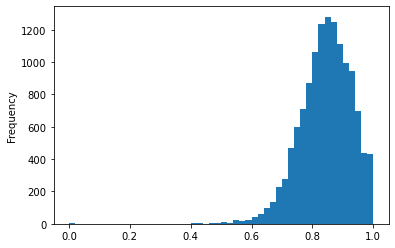

In [45]:
cosine_distances[30378191].plot.hist(bins=50)

In [47]:
cosine_distances[cosine_distances[30378191] < 0.5]

,13913.0,17506.0,25123.0,38605.0,38950.0,40228.0,41311.0,41712.0,42001.0,43129.0,...,45063293.0,45063367.0,45065675.0,45066548.0,45067269.0,45077803.0,45081264.0,45081587.0,45083401.0,45085490.0
5825874.0,0.952002,0.937040,0.897429,0.930911,0.791305,0.727531,0.897429,0.907081,0.902049,0.928970,...,0.954774,0.954774,0.883743,0.842946,0.930284,0.734124,0.919064,0.939254,0.750802,0.526091
9348204.0,0.858752,0.917452,0.812201,0.966689,0.832273,0.857244,0.812201,0.932015,0.775526,0.912682,...,0.922128,0.922128,0.913425,0.946467,0.961876,0.769642,1.000000,0.767322,0.926922,0.847246
9491347.0,0.858752,0.917452,0.812201,0.966689,0.832273,0.857244,0.812201,0.932015,0.775526,0.912682,...,0.922128,0.922128,0.913425,0.946467,0.961876,0.769642,1.000000,0.767322,0.926922,0.847246
11156202.0,0.858752,0.917452,0.812201,0.966689,0.832273,0.857244,0.812201,0.932015,0.775526,0.912682,...,0.922128,0.922128,0.913425,0.946467,0.961876,0.769642,1.000000,0.767322,0.926922,0.847246
26719908.0,0.824481,0.879066,0.763985,0.795887,0.768874,0.796528,0.763985,0.850261,0.789904,0.896256,...,0.863895,0.863895,0.860592,0.737781,0.955203,0.693473,0.950230,0.773990,0.955273,0.785821
30378191.0,0.823671,0.843270,0.719921,0.874461,0.709690,0.739558,0.719921,0.861310,0.883933,0.820202,...,0.908672,0.908672,0.834779,0.941173,0.818057,0.738342,0.981607,0.808926,0.814820,0.638006
30378371.0,0.823671,0.843270,0.719921,0.874461,0.709690,0.739558,0.719921,0.861310,0.883933,0.820202,...,0.908672,0.908672,0.834779,0.941173,0.818057,0.738342,0.981607,0.808926,0.814820,0.638006
32446731.0,0.823671,0.843270,0.719921,0.874461,0.709690,0.739558,0.719921,0.861310,0.883933,0.820202,...,0.908672,0.908672,0.834779,0.941173,0.818057,0.738342,0.981607,0.808926,0.814820,0.638006
36760355.0,0.875294,0.853819,0.833578,0.765625,0.764091,0.766229,0.833578,0.881327,0.815133,0.902362,...,0.919722,0.919722,0.908684,0.962619,0.867705,0.854496,0.985797,0.904996,0.799916,0.754406
36760367.0,0.850698,0.812939,0.848909,0.866912,0.738697,0.756816,0.848909,0.812299,0.837386,0.865831,...,0.899482,0.899482,0.902746,0.939660,0.891552,0.851420,0.985497,0.902987,0.780867,0.749214


In [56]:
merged_df[merged_df['id'] == 44659434][['description', 'host_id']]

,description,host_id
31654,"Just a stone throw from King's Cross St Pancras station is this exquisite gem of an rooms. The bright, spacious, fully-furnished rooms with home comforts to ensure an enjoyable stay. <br /><br />Perfect for couples, families & friends on a city break, or business travellers! <br /><br />-\t1 Quad Bedroom with kitchen facility and dining area, Shared Bathroom<br /><br /><b>The space</b><br />Great cosy bedroom for 4 people only Minutes away from Kings Cross - Eurostar Station. Beautiful, bright, private bedroom for 4 people with shared bathroom. This private bedroom is only minutes away from Kings Cross. Self-check-in facility and newly refurbished throughout. Walking distance to King’s Cross St Pancras for trains all over the UK and Eurostar to Paris, Brussels and Amsterdam. It is only 15 mins walk from University College London Hospital<br />Hotel quality linens and towels are provided.",259278549


<AxesSubplot:ylabel='Frequency'>

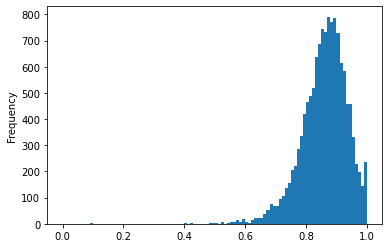

In [61]:
cosine_distances[44659433].plot.hist(bins=100)

#### Identifying listings that have multiple low cosine distances

In [62]:
cosine_distances[(cosine_distances < 0.2).sum(1) > 2]

,13913.0,17506.0,25123.0,38605.0,38950.0,40228.0,41311.0,41712.0,42001.0,43129.0,...,45063293.0,45063367.0,45065675.0,45066548.0,45067269.0,45077803.0,45081264.0,45081587.0,45083401.0,45085490.0
25123.0,0.928287,0.840870,0.000000,0.797349,0.768436,0.784954,0.000000,0.898682,0.778578,0.750546,...,0.887773,0.887773,0.764521,0.837112,0.928732,0.840263,0.903731,0.766158,0.941996,0.918433
41311.0,0.928287,0.840870,0.000000,0.797349,0.768436,0.784954,0.000000,0.898682,0.778578,0.750546,...,0.887773,0.887773,0.764521,0.837112,0.928732,0.840263,0.903731,0.766158,0.941996,0.918433
216350.0,0.733215,0.849522,0.875722,0.858245,0.749408,0.753520,0.875722,0.799422,0.745057,0.861136,...,0.848114,0.848114,0.806753,0.752476,0.827261,0.804862,0.886772,0.855537,0.873483,0.879377
236956.0,0.744532,0.922907,0.772427,0.863872,0.840713,0.805633,0.772427,0.936760,0.895893,0.809512,...,0.743700,0.743700,0.893599,0.712947,0.930628,0.825805,0.926491,0.921274,0.798259,0.928919
268398.0,0.762821,0.927091,0.771006,0.871761,0.822477,0.780279,0.771006,0.946417,0.889218,0.831516,...,0.700770,0.700770,0.905624,0.687624,0.917270,0.835257,0.902309,0.925546,0.794375,0.932776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45063153.0,0.772143,0.927199,0.887773,0.873700,0.878677,0.871319,0.887773,0.827584,0.863145,0.901599,...,0.000000,0.000000,0.915765,0.900060,0.907401,0.801339,0.779385,0.924901,0.836600,0.906443
45063218.0,0.772143,0.927199,0.887773,0.873700,0.878677,0.871319,0.887773,0.827584,0.863145,0.901599,...,0.000000,0.000000,0.915765,0.900060,0.907401,0.801339,0.779385,0.924901,0.836600,0.906443
45063293.0,0.772143,0.927199,0.887773,0.873700,0.878677,0.871319,0.887773,0.827584,0.863145,0.901599,...,0.000000,0.000000,0.915765,0.900060,0.907401,0.801339,0.779385,0.924901,0.836600,0.906443
45063367.0,0.772143,0.927199,0.887773,0.873700,0.878677,0.871319,0.887773,0.827584,0.863145,0.901599,...,0.000000,0.000000,0.915765,0.900060,0.907401,0.801339,0.779385,0.924901,0.836600,0.906443


In [63]:
cosine_distances.loc[[45063218, 45063293, 45063367], [45063218, 45063293, 45063367]]

,45063218,45063293,45063367
45063218,0.0,0.0,0.0
45063293,0.0,0.0,0.0
45063367,0.0,0.0,0.0


In [66]:
merged_df.set_index('id', inplace=True)

In [67]:
merged_df.loc[[45063218, 45063293, 45063367], ['description', 'host_id']] #it's picking up on ghost hotels with multiple associated accounts!

,description,host_id
id,,
45063218,"Our self contained modern and spacious double bedroom in Notting Hill/Westbourne Park minutes walk from the Underground.<br />The apartment is one of five purposely-built double and triple room lets in this brand new block of apartments.<br />The building has a communal shower/bathroom, which is deep cleaned daily along with all communal areas.<br /><br /><b>The space</b><br />The apartments are all designed by ‘Slim Interior Design’ with a chic, modern minimalist brief.<br />The flat has been finished to an excellent standard and comes fully furnished with a modern bathroom with shower & bath, laminate floors throughout, modern furniture and fittings.<br />We have also taking preventative measures to ensure guests have a safe stay with us with CCTV in communal areas, wireless check-in, daily communal cleans.<br />These double rooms are suitable for couples or single guests.<br /><br /><b>Guest access</b><br />Guest have access to their own room as well as the communal areas.<br /><br",265006671
45063293,"Our self contained modern and spacious double bedroom in Notting Hill/Westbourne Park minutes walk from the Underground.<br />The apartment is one of five purposely-built double and triple room lets in this brand new block of apartments.<br />The building has a communal shower/bathroom, which is deep cleaned daily along with all communal areas.<br /><br /><b>The space</b><br />The apartments are all designed by ‘Slim Interior Design’ with a chic, modern minimalist brief.<br />The flat has been finished to an excellent standard and comes fully furnished with a modern bathroom with shower & bath, laminate floors throughout, modern furniture and fittings.<br />We have also taking preventative measures to ensure guests have a safe stay with us with CCTV in communal areas, wireless check-in, daily communal cleans.<br />These double rooms are suitable for couples or single guests.<br /><br /><b>Guest access</b><br />Guest have access to their own room as well as the communal areas.<br /><br",36126550
45063367,"Our self contained modern and spacious double bedroom in Notting Hill/Westbourne Park minutes walk from the Underground.<br />The apartment is one of five purposely-built double and triple room lets in this brand new block of apartments.<br />The building has a communal shower/bathroom, which is deep cleaned daily along with all communal areas.<br /><br /><b>The space</b><br />The apartments are all designed by ‘Slim Interior Design’ with a chic, modern minimalist brief.<br />The flat has been finished to an excellent standard and comes fully furnished with a modern bathroom with shower & bath, laminate floors throughout, modern furniture and fittings.<br />We have also taking preventative measures to ensure guests have a safe stay with us with CCTV in communal areas, wireless check-in, daily communal cleans.<br />These double rooms are suitable for couples or single guests.<br /><br /><b>Guest access</b><br />Guest have access to their own room as well as the communal areas.<br /><br",36126550
